In [1]:
from torch.utils.data import Dataset
from collections import defaultdict
from random import choice
import torchvision
import numpy as np
import matplotlib.pyplot as plt

In [21]:
import torch
import torch.nn as nn
import torch.nn.functional as F


class _BNReluConv(nn.Sequential):
    def __init__(self, num_maps_in, num_maps_out, k=3, bias=True):
        super(_BNReluConv, self).__init__()
        self.append(torch.nn.BatchNorm2d(num_maps_in, affine=bias))
        self.append(torch.nn.ReLU())
        self.append(torch.nn.Conv2d(num_maps_in, num_maps_out, kernel_size=k))


class SimpleMetricEmbedding(nn.Module):
    def __init__(self, input_channels, emb_size=32):
        super().__init__()
        self.emb_size = emb_size
        self.block_1 = _BNReluConv(input_channels, emb_size)
        self.maxpool_1 = torch.nn.MaxPool2d(kernel_size=3, stride=2)
        self.block_2 = _BNReluConv(emb_size, emb_size)
        self.maxpool_2 = torch.nn.MaxPool2d(kernel_size=3, stride=2)
        self.block_3 = _BNReluConv(emb_size, emb_size)
        self.avg_global = nn.AvgPool2d(kernel_size=2)
        self.margin = 1

    def get_features(self, img: torch.Tensor):
        x = self.block_1(img)
        x = self.maxpool_1(x)
        x = self.block_2(x)
        x = self.maxpool_2(x)
        x = self.block_3(x)
        x = self.avg_global(x)
       # x = x.reshape((img.size(dim=0), self.emb_size))
        x=x.squeeze()
        return x

    def loss(self, anchor, positive, negative):
        a_x = self.get_features(anchor)
        p_x = self.get_features(positive)
        n_x = self.get_features(negative)
        distance_positive = F.pairwise_distance(a_x, p_x, p=2)
        distance_negative = F.pairwise_distance(a_x, n_x, p=2)
        loss = torch.maximum(torch.tensor(0), distance_positive - distance_negative + self.margin)
        loss = torch.mean(loss)
        return loss


In [3]:
class MNISTMetricDataset(Dataset):
    def __init__(self, root="/tmp/mnist/", split='train'):
        super().__init__()
        assert split in ['train', 'test', 'traineval']
        self.root = root
        self.split = split
        mnist_ds = torchvision.datasets.MNIST(self.root, train='train' in split, download=True)
        self.images, self.targets = mnist_ds.data.float() / 255., mnist_ds.targets
        self.classes = list(range(10))

        self.target2indices = defaultdict(list)
        for i in range(len(self.images)):
            self.target2indices[self.targets[i].item()] += [i]

    def _sample_negative(self, index):
        # YOUR CODE HERE
        """
        returns index of a random negative example
        """
        target=self.targets[index].item()
        negative_indices=[]
        t2i=self.target2indices
        for key in t2i.keys():
            if key!=target:
                negative_indices.extend(t2i[key])
        return choice(negative_indices)


    def _sample_positive(self, index):
        # YOUR CODE HERE
        """
        returns index of a random positive example
        """
        target=self.targets[index].item()
        positive_indices=self.target2indices[target]
        return choice(positive_indices)


    def __getitem__(self, index):
        anchor = self.images[index].unsqueeze(0)
        target_id = self.targets[index].item()
        if self.split in ['traineval', 'val', 'test']:
            return anchor, target_id
        else:
            positive = self._sample_positive(index)
            negative = self._sample_negative(index)
            positive = self.images[positive]
            negative = self.images[negative]
            return anchor, positive.unsqueeze(0), negative.unsqueeze(0), target_id

In [4]:
mnist=MNISTMetricDataset()

In [5]:
imgs=mnist.images
tar=mnist.targets
cl=mnist.classes
t2i=mnist.target2indices

t2i_3=t2i[3]
trice=imgs[t2i_3]

t2i_ne_3=[]
print(t2i.keys())

dict_keys([5, 0, 4, 1, 9, 2, 3, 6, 7, 8])


In [22]:
model=SimpleMetricEmbedding(1, 32)
mnist7=mnist[7]
a,pos,neg,target=mnist7
batch7=torch.stack([a, pos, neg,a,a,pos])
res=model.get_features(batch7)
print(res)

tensor([[ 0.4505, -0.2968, -0.0213, -0.2273,  0.3306, -0.1214,  0.3034, -0.0138,
         -0.3429, -0.1332, -0.3731, -0.4377, -0.3464, -0.5909,  0.6982,  0.2655,
         -0.0820,  0.2079,  0.1540, -0.1455,  0.3311, -0.0015, -0.0853,  0.3469,
         -0.4594,  0.3831, -0.3170,  0.0648, -0.1126,  0.1521,  0.1969, -0.4338],
        [ 0.8185,  0.0779, -0.0992, -0.1640,  0.3688,  0.6954,  0.6581, -0.1999,
         -0.2572,  0.2811, -0.3901, -0.2150,  0.4417, -0.1089,  0.9031,  0.4165,
         -0.5350,  0.1841,  0.2925, -0.1003,  0.5077,  0.0651,  0.2343,  0.2654,
         -0.6433,  0.1148, -0.2517,  0.2836, -0.0568,  0.0308, -0.1432, -0.6114],
        [ 0.3185,  0.4339, -0.2906, -0.4820,  0.2034, -0.0498,  0.4631, -0.1441,
         -0.1549,  0.4255, -0.1236, -0.4192,  0.0322, -0.2747,  0.4720,  0.1620,
         -0.3771,  0.4559,  0.1225, -0.2042,  0.3815, -0.1722,  0.3357,  0.3338,
         -0.2761,  0.4095,  0.1754, -0.2570,  0.2610, -0.1731,  0.1467, -0.5269],
        [ 0.4505, -0.2968

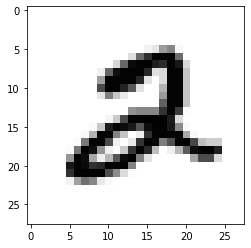

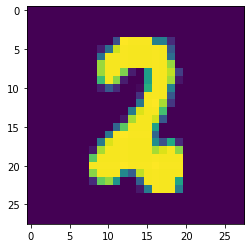

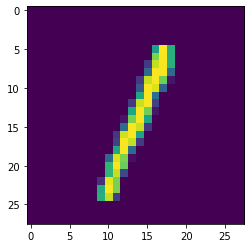

2


In [7]:
a,pos, neg, target=mnist[5]
plt.imshow(-1* a.squeeze(), cmap='gray')
plt.show()
plt.imshow(pos.squeeze())
plt.show()
plt.imshow(neg.squeeze())
plt.show()
print(target)
